In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


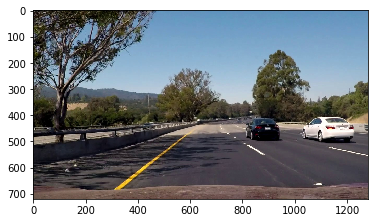

In [4]:
#reading in an image
image = mpimg.imread('test_video_frames_challenge/frame89.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

In [8]:
import math

# Calculate image height and width
h = image.shape[0]
w = image.shape[1]

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines_part1(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """    
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
                 

def draw_lines_part2(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    # Making left/right x and y lists global.
    global x_p_l 
    global y_p_l
    global x_p_r 
    global y_p_r
    
    # Initializing the lists as empty.
    x_p_l = []
    y_p_l = []
    x_p_r = []
    y_p_r = []
    slope_l = []
    slope_r = []
    
    # Sorting points into left x and y OR right x and y lists, 
    # based on slope range.
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = ((y2-y1)/(x2-x1))
            if not np.isnan(slope) or np.isinf(slope) or (slope == 0):
                if slope < -0.6 and slope > -1:
                    x_p_l += [x1, x2]
                    y_p_l += [y1, y2]
                    slope_l += [slope]
                elif slope > 0.2 and slope < 1.5:
                    x_p_r += [x1, x2]
                    y_p_r += [y1, y2]
                    slope_r += [slope]
    
    # Average out the x and y points, and calculate the mean slopes.
    avg_x_l = np.mean(x_p_l, dtype=np.float32)
    avg_x_r = np.mean(x_p_r, dtype=np.float32)
    avg_y_l = np.mean(y_p_l, dtype=np.float32)
    avg_y_r = np.mean(y_p_r, dtype=np.float32)
    avg_slope_l = np.mean(slope_l, dtype=np.float32)
    avg_slope_r = np.mean(slope_r, dtype=np.float32)
    
    # Calculate intercepts from the means above
    # b = y - mx
    b_l = avg_y_l - (avg_slope_l * avg_x_l)
    b_r = avg_y_r - (avg_slope_r * avg_x_r)
    
    # Calculate X coordinates of the lines to be drawn
    # using information above. The Y values are the 
    # y coordinates of the bounding box/mask as defined
    # in the pipeline further below.
    y_max = y_mask[0]
    y_min = y_mask[1]
    x_max_l = max(x_p_l)
    x_max_r = max(x_p_r)
    x_min_l = min(x_p_l)
    x_min_r = min(x_p_r)
    
    # X = (Y - b) / m
    X_l_lo = (y_max - b_l) / avg_slope_l
    X_l_hi = (y_min - b_l) / avg_slope_l
    
    X_r_lo = (y_max - b_r) / avg_slope_r
    X_r_hi = (y_min - b_r) / avg_slope_r
    
    # Draw lines on the left side and the right side of the image
    # using cv2.line() function, and (X,Y) calculated above as points. 
    if not np.isnan(X_l_lo) or np.isnan(X_l_hi) or np.isnan(X_r_lo) or np.isnan(X_r_hi):
        img_l = cv2.line(img, (int(X_l_lo), y_max), (int(X_l_hi), y_min), color, thickness)
        cv2.line(img_l, (int(X_r_lo), y_max), (int(X_r_hi), y_min), color, thickness)
    else:
        img_l = cv2.line(img, (int(x_min_l), y_max), (int(x_max_l), y_min), color, thickness)
        cv2.line(img_l, (int(x_max_r), y_max), (int(x_min_r), y_min), color, thickness)
        
            
    
        
def hough_lines_p1(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines_part1(line_img, lines)
    return line_img

def hough_lines_p2(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines_part2(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def draw_roi(img):
    """
    `img` is the output of the weighted_img(), an image with lines drawn on it.
    
    The resultant image has ROI drawn on it using cv2.polylines().
    
    """
    pts = np.array([[(w//10 + 4,h),((w//2 - 60), (h//2) + 60), \
                        ((w//2 + 80), (h//2) + 60), (w - 20,h)]], dtype=np.int32)
    cv2.polylines(img, pts, False, [0,0,255], thickness=4)   

In [9]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

############################## Pipeline ############################

def lane_pipeline(img):
    
    # Make a copy
    im_copy = np.copy(img)
    

    # Step 1: Convert to grayscale.  
    # Use 'im_copy' as input; use cmap='gray' to see the returned image as grayscale.
    # Save result to 'gray'.
    gray = grayscale(im_copy)
    # display the grayscale image here:
    #plt.imshow(gray, cmap='gray') and plt.xlabel('Grayscaled image') and plt.show()

    # Step 2: Apply Gaussian smoothing/blurring 
    # Use 'gray' as input; use a 5x5 kernel.
    # Save result to 'blur_gray'.
    blur_gray = gaussian_blur(gray, 5)

    # Step 3: Run Canny edge detection 
    # Use 'blur_gray' as input; specify low_threshold and high_threshold values.
    # Save result to 'edges'.
    edges = canny(blur_gray, 80, 200)
    # display the image
    #plt.imshow(edges, cmap='Greys_r') and plt.xlabel('Canny edge detected image') and plt.show()
    # Save the edge map in 'test_images_canny_output/'
    #mpimg.imsave('test_video_frames_solidYellowLeft/canny.jpg', comb_edges)
    # Stack the 'edges' to make it a 3-channel image,
    # and save the result to 'comb_edges'.
    comb_edges = np.dstack((edges, edges, edges))

    # Step 4: Apply Region Masking
    # Use 'edges' as input; define the vertices and call the function 'region_of_interest()'.
    # Save result to 'masked_edges'.
 
    height = im_copy.shape[0]
    width = im_copy.shape[1]
    v_poly = np.array([[(width//10 + 4,height),((width//2 - 60), (height//2) + 60), \
                        ((width//2 + 80), (height//2) + 60), (width - 20,height)]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices=v_poly)
    
    # Save the masked_edges image in 'test_images_masked_output/'
    #mpimg.imsave('test_images_masked_output/masked_edges.jpg', comb_masked_edges)
    # Stack the 'masked_edges' to make it a 3-channel image,
    # and save the result to 'comb_masked_edges'.
    comb_masked_edges = np.dstack((masked_edges, masked_edges, masked_edges))
    
    # Make the x_mask,y_mask global.
    global x_mask
    global y_mask 
    
    # Define x_mask,y_mask as the coordinates of the vertices of the polygon ROI.    
    x_mask = [v_poly[0][0][0], v_poly[0][1][0], v_poly[0][2][0], v_poly[0][3][0], v_poly[0][0][0]]
    y_mask = [v_poly[0][0][1], v_poly[0][1][1], v_poly[0][2][1], v_poly[0][3][1], v_poly[0][0][1]]
    
    # Step 5: Run Hough Transform
    # Use 'masked_edges' as input; pass in suitable values to rho, theta etc.
    # Save result to 'hough_image'.
    # This uses the updated draw_lines() function. 
    hough_image = hough_lines_p2(masked_edges, rho=2, theta=np.pi/360, threshold=40, min_line_len=10, max_line_gap=20)
    # Save hough_image to a folder. 
    #mpimg.imsave('test_images_hough_output/hough.jpg', hough_image)  
    
    # Display the region mask on the original image
    # and plot the points on lines detected by hough transform
    #plt.imshow(im_copy)    
    #plt.plot(x_mask, y_mask, 'b', lw=4)   
    #plt.plot(x_p_l, y_p_l, 'ro') and plt.plot(x_p_r, y_p_r, 'ro') and plt.show()

    # Step 6: Draw the hough lines on the original image
    # Call weighted_img() with 'hough_image' and 'im_copy' as arguments.
    # Save result to 'lines_image'
    lines_image = weighted_img(hough_image, im_copy)
    #draw_roi(lines_image)

    # Display the final result (Hough lines on the original image)
    #plt.imshow(lines_image) and plt.xlabel('Hough lines on the original image') and plt.show()

    # Save the images to test_images_output/
    #mpimg.imsave('test_images_output/result.jpg', lines_image)
    
    # Return the final processed image.
    return lines_image

In [10]:
######### Checking the pipeline on test_images #########

# For every file in 'test_images/':
for i in os.listdir("test_video_frames_challenge/"):
    # Read the image.
    image = mpimg.imread('test_video_frames_challenge/' + i)
    # Call the pipeline function. 
    processed_image = lane_pipeline(image)
    # Display the processed images.
    mpimg.imsave('test_video_frames_output/' + i, processed_image)

ValueError: max() arg is an empty sequence

In [17]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    # TODO: Build your pipeline that will draw lane lines on the test_images
    # then save them to the test_images directory.
    
    # Return the pipeline function call to the input image.    
    return lane_pipeline(image)

In [18]:
# Make sure the directory 'test_videos_output/' exists
# If not, create one here:
if os.path.exists('test_videos_output/p1_examples/'):
    print('Directory exists.')    
else:
    os.mkdir('test_videos_output/p1_examples/')

Directory exists.


In [ ]:
# Convert video to images 
########## Used for debugging certain frames ############
# Create a folder to store extracted images

# Uncomment the following lines to extract images 
# from the specific test videos.

# folder = 'test_video_frames_solidWhiteRight/'
# folder = 'test_video_frames_challenge/'
folder = 'test_video_frames_solidYellowLeft/'
if os.path.exists(folder):
    print('Directory exists. Extracting images...')
else:
    os.mkdir(folder)
vidcap = cv2.VideoCapture('test_videos/solidYellowLeft.mp4')
count = 0
while True:
    success,image = vidcap.read()
    if not success:
        break
    # save frame as JPEG file
    cv2.imwrite(os.path.join(folder,"frame{:d}.jpg".format(count)), image)     
    count += 1
print("{} images are extracted in {}.".format(count,folder))

In [19]:
white_output = 'test_videos_output/p1_examples/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/p1_examples/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/p1_examples/solidWhiteRight.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 221/222 [00:03<00:00, 63.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/p1_examples/solidWhiteRight.mp4 

Wall time: 3.9 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [20]:
yellow_output = 'test_videos_output/p1_examples/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/p1_examples/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/p1_examples/solidYellowLeft.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 681/682 [00:15<00:00, 38.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/p1_examples/solidYellowLeft.mp4 

Wall time: 16.4 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

In [21]:
challenge_output = 'test_videos_output/p1_examples/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/p1_examples/challenge.mp4
[MoviePy] Writing video test_videos_output/p1_examples/challenge.mp4


 41%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 103/251 [00:03<00:04, 30.35it/s]

ValueError: cannot convert float NaN to integer

 41%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 103/251 [00:20<00:28,  5.15it/s]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))